## Metropolis Algorithm

Metropolis, N., Rosenbluth, A. W., Rosenbluth, M. N., Teller, A. H., & Teller, E. (1953). Equation of state calculations by fast computing machines. The journal of chemical physics, 21(6), 1087-1092.

The Metropolis algorithm is an instance of the MCMC class of algorithms, with the purpose of sampling from a posterior distribution that may be intractable to manipulate analytically.

Let's start with a simple example:
 - Suppose you want to find the posterior distribution over the bias $\theta$ of a coin, given
a list of $n$ observations $X_i$. 
 - We start with a uniform prior: $\theta \sim \mathsf{Uniform}(0,1)$, and consider the binomial likelihood: $X \mid \theta \sim \mathsf{Binomial}(n, \theta)$.
 - The posterior will be $p(\theta \mid X) = \dfrac{p(X\mid\theta) \cdot p(\theta)}{Z_p}$, where $Z_p=\int_0^1{p(X\mid\theta) \cdot p(\theta) d\theta}$ is the normalising constant.

Let's assume that $Z_p$ is "intractable", so we will use the Metropolis algorithm to sample from the posterior. 

First, we need a **symmetric proposal distribution**, that will give us a new potential sample to move to. Next, the acceptance probability of moving to a new sample $\theta^\star$ given the current sample $\theta_t$ is 
$$
\min\left(1, \ \dfrac{p(\theta^\star \mid X)}{p(\theta_t \mid X)}\right) = \min\left(1, \ \dfrac{p(X\mid\theta^\star)\cdot p(\theta^\star)}{p(X\mid\theta_t)\cdot p(\theta_t)}\right)
$$
which can now be evaluated, since the likelihood and the prior are known.

The term $p(X\mid\theta)\cdot p(\theta)$ is often called the **unnormalised posterior**, and it is assumed that it can be evaluated. 

### Notes
- The Metropolis-Hastings algorithm is a generalization of the Metropolis algorithm, such that the proposal distribution does not have to symmetric.

In [1]:
import numpy as np
import scipy.stats as stats
from sympy import integrate, symbols

import itertools
from collections import namedtuple
from tqdm import trange
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
Observation = namedtuple('Observation', ['n', 'k'])

class BaseModel:
    pass

class BiasedCoinModel(BaseModel):
    """Given observed data X, construct a model that will be used
    by algorithms to sample from the posterior distribution (θ | X).
    
    A model must implement the following functions: 
        get_starting_point, prior, likelihood, proposal.
    """
    def __init__(self, obs: Observation):
        self.obs = obs
        
    def ground_truth_density(self):
        """Computes the actual posterior density f(θ | X).
        observation 
            (n, k)
        prior 
            θ ~ uniform(0,1)
            f(θ) = 1
        likelihood
            X | θ ~ binom(n, θ).pmf(k)
            f(X | θ) = (n k) * (θ**k) * (1-θ)**(n-k)
        normalising constant
            Z = int(0,1) likelihood * prior dθ
            Z = int(0,1) (θ**k) * (1-θ)**(n-k) dθ
            (n k) cancels with the (n k) from the numerator
        """
        n, k = self.obs.n, self.obs.k
        x = symbols('x')

        Z = integrate(f"x**{k} * (1-x)**{n-k}", (x, 0, 1))
        Z = float(Z.evalf())

        def inner(θ):
            return θ**k * (1-θ)**(n-k) / Z
        return inner
        
    def get_starting_point(self) -> float:
        """Starting point θ_0, for which p(θ_0 | X) > 0."""
        return 0.5
        
    def prior(self, theta: float) -> float:
        """Prior density function: f(θ)"""
        return stats.uniform(0, 1).pdf(theta)

    def likelihood(self, theta: float):
        """Likelihood density function: f(X | θ)"""
        if not (0 <= theta <= 1):
            return 0
        return stats.binom(n=self.obs.n, p=theta).pmf(self.obs.k)
    
    def unnormalised_posterior(self, theta, use_log=False):
        """Convenience wrapper over the likelihood & prior densities we have access to."""
        l = self.likelihood(theta)
        p = self.prior(theta)
        
        if use_log:
            return np.log(l) + np.log(p)
   
        return l * p

    def proposal(self, cur_theta: float, step_size: float):
        """Samples the next value from the proposal distribution: q(θ_t | θ_t-1)
        Note:
            For the Metropolis algorithm, the proposal distribution must be symmetric, i.e.
            q(a | b) = q(b | a)
        """
        return cur_theta + stats.norm(loc=0, scale=step_size).rvs()
        # return cur_theta + stats.uniform(loc=-step_size, scale=1).rvs()

In [3]:
def metropolis(model: BaseModel, num_iters: int, step_size: float) -> np.array:
    theta = model.get_starting_point()
    samples = np.zeros(num_iters)
    
    for t in trange(num_iters, desc=f'Metropolis ({num_iters=} | {step_size=})'):
        # propose a new theta
        theta_new = model.proposal(theta, step_size=step_size)
        
        # ratio_top = model.likelihood(theta_new) * model.prior(theta_new)
        # ratio_bot = model.likelihood(theta)     * model.prior(theta)
        ratio_top = model.unnormalised_posterior(theta_new)
        ratio_bot = model.unnormalised_posterior(theta)
            
        if np.isclose(ratio_top, 0):
            acc_prob = 0
        elif ratio_top > ratio_bot:
            acc_prob = 1
        else:
            acc_prob = min(1, ratio_top / ratio_bot)
        
        u = np.random.uniform()
        if u < acc_prob:
            theta = theta_new
        
        samples[t] = theta
    
    return samples

### Run

In [4]:
obs = Observation(n=20, k=17)

model = BiasedCoinModel(obs)

param_grid = {
    'num_iters': [100, 1_000, 10_000],
    'step_size': [0.05, 0.2, 0.5, 1],
}

posteriors = []

for values in itertools.product(*param_grid.values()):
    kwargs = dict(zip(param_grid.keys(), values))
    
    p = metropolis(model, **kwargs)
    
    posteriors.append({**kwargs, **{'samples': p}})

Metropolis (num_iters=100 | step_size=0.05): 100%|█████████████████████████████████| 100/100 [00:00<00:00, 267.63it/s]
Metropolis (num_iters=100 | step_size=0.2): 100%|██████████████████████████████████| 100/100 [00:00<00:00, 254.45it/s]
Metropolis (num_iters=100 | step_size=0.5): 100%|██████████████████████████████████| 100/100 [00:00<00:00, 276.29it/s]
Metropolis (num_iters=100 | step_size=1): 100%|████████████████████████████████████| 100/100 [00:00<00:00, 245.06it/s]
Metropolis (num_iters=1000 | step_size=0.05): 100%|██████████████████████████████| 1000/1000 [00:03<00:00, 271.10it/s]
Metropolis (num_iters=1000 | step_size=0.2): 100%|███████████████████████████████| 1000/1000 [00:02<00:00, 333.48it/s]
Metropolis (num_iters=1000 | step_size=0.5): 100%|███████████████████████████████| 1000/1000 [00:02<00:00, 349.81it/s]
Metropolis (num_iters=1000 | step_size=1): 100%|█████████████████████████████████| 1000/1000 [00:02<00:00, 354.35it/s]
Metropolis (num_iters=10000 | step_size=0.05): 1

### Density plots

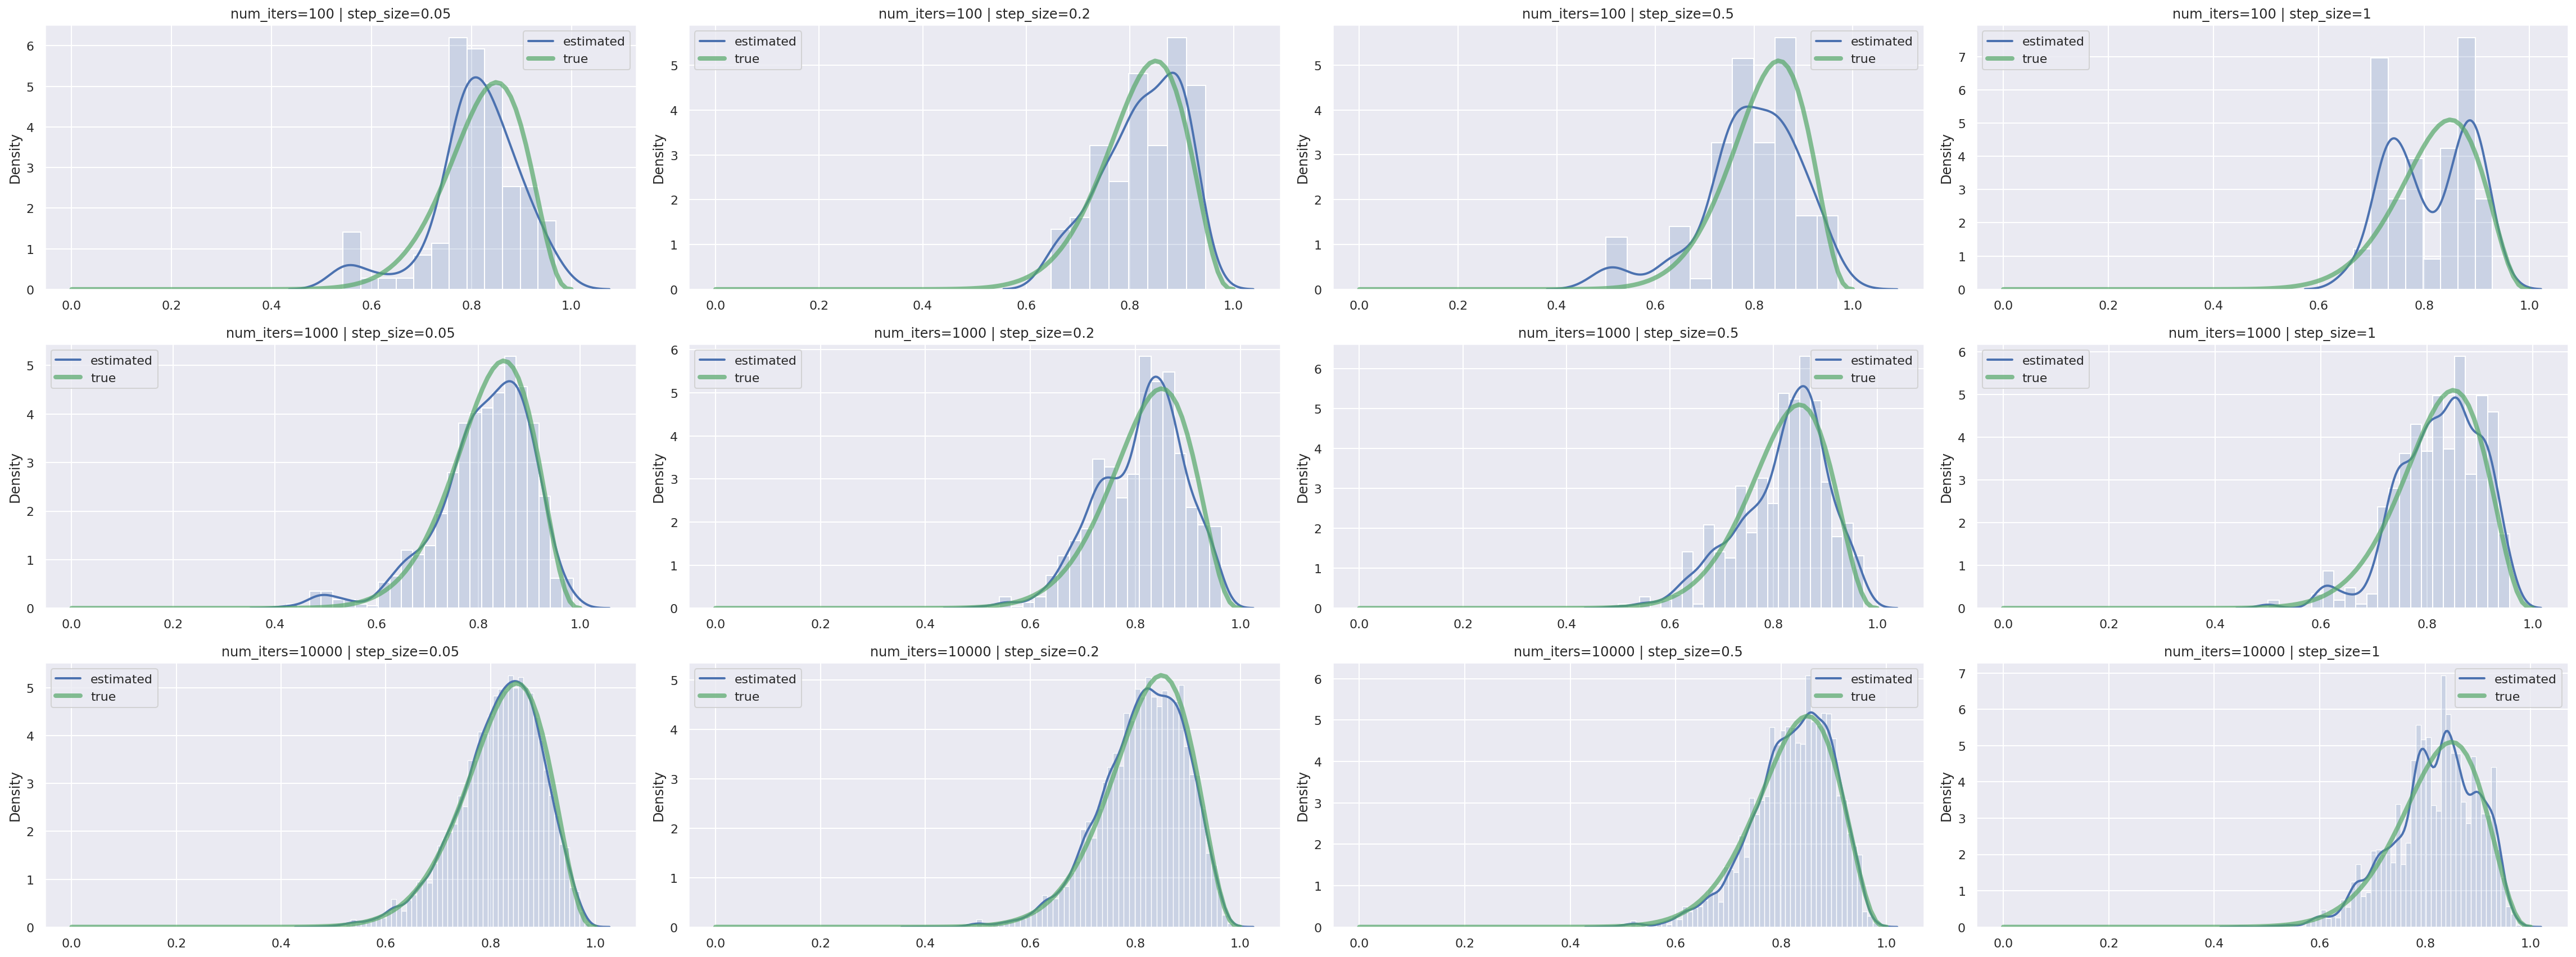

In [5]:
plt.figure(figsize=(32, 12))

for i in range(len(posteriors)):
    p = posteriors[i]
    
    plt.subplot(3, 4, i+1)
    plt.title(f"num_iters={p['num_iters']} | step_size={p['step_size']}", fontsize=12)
    
    sns.histplot(p['samples'], stat='density', alpha=0.2)
    sns.kdeplot(p['samples'], color='b', lw=2, label='estimated')

    post = model.ground_truth_density()
    xs = np.linspace(0, 1, 100)
    plt.plot(xs, [post(x) for x in xs], c='g', lw=4, alpha=0.7, label='true')

    plt.legend()

plt.tight_layout()

### Trace plots

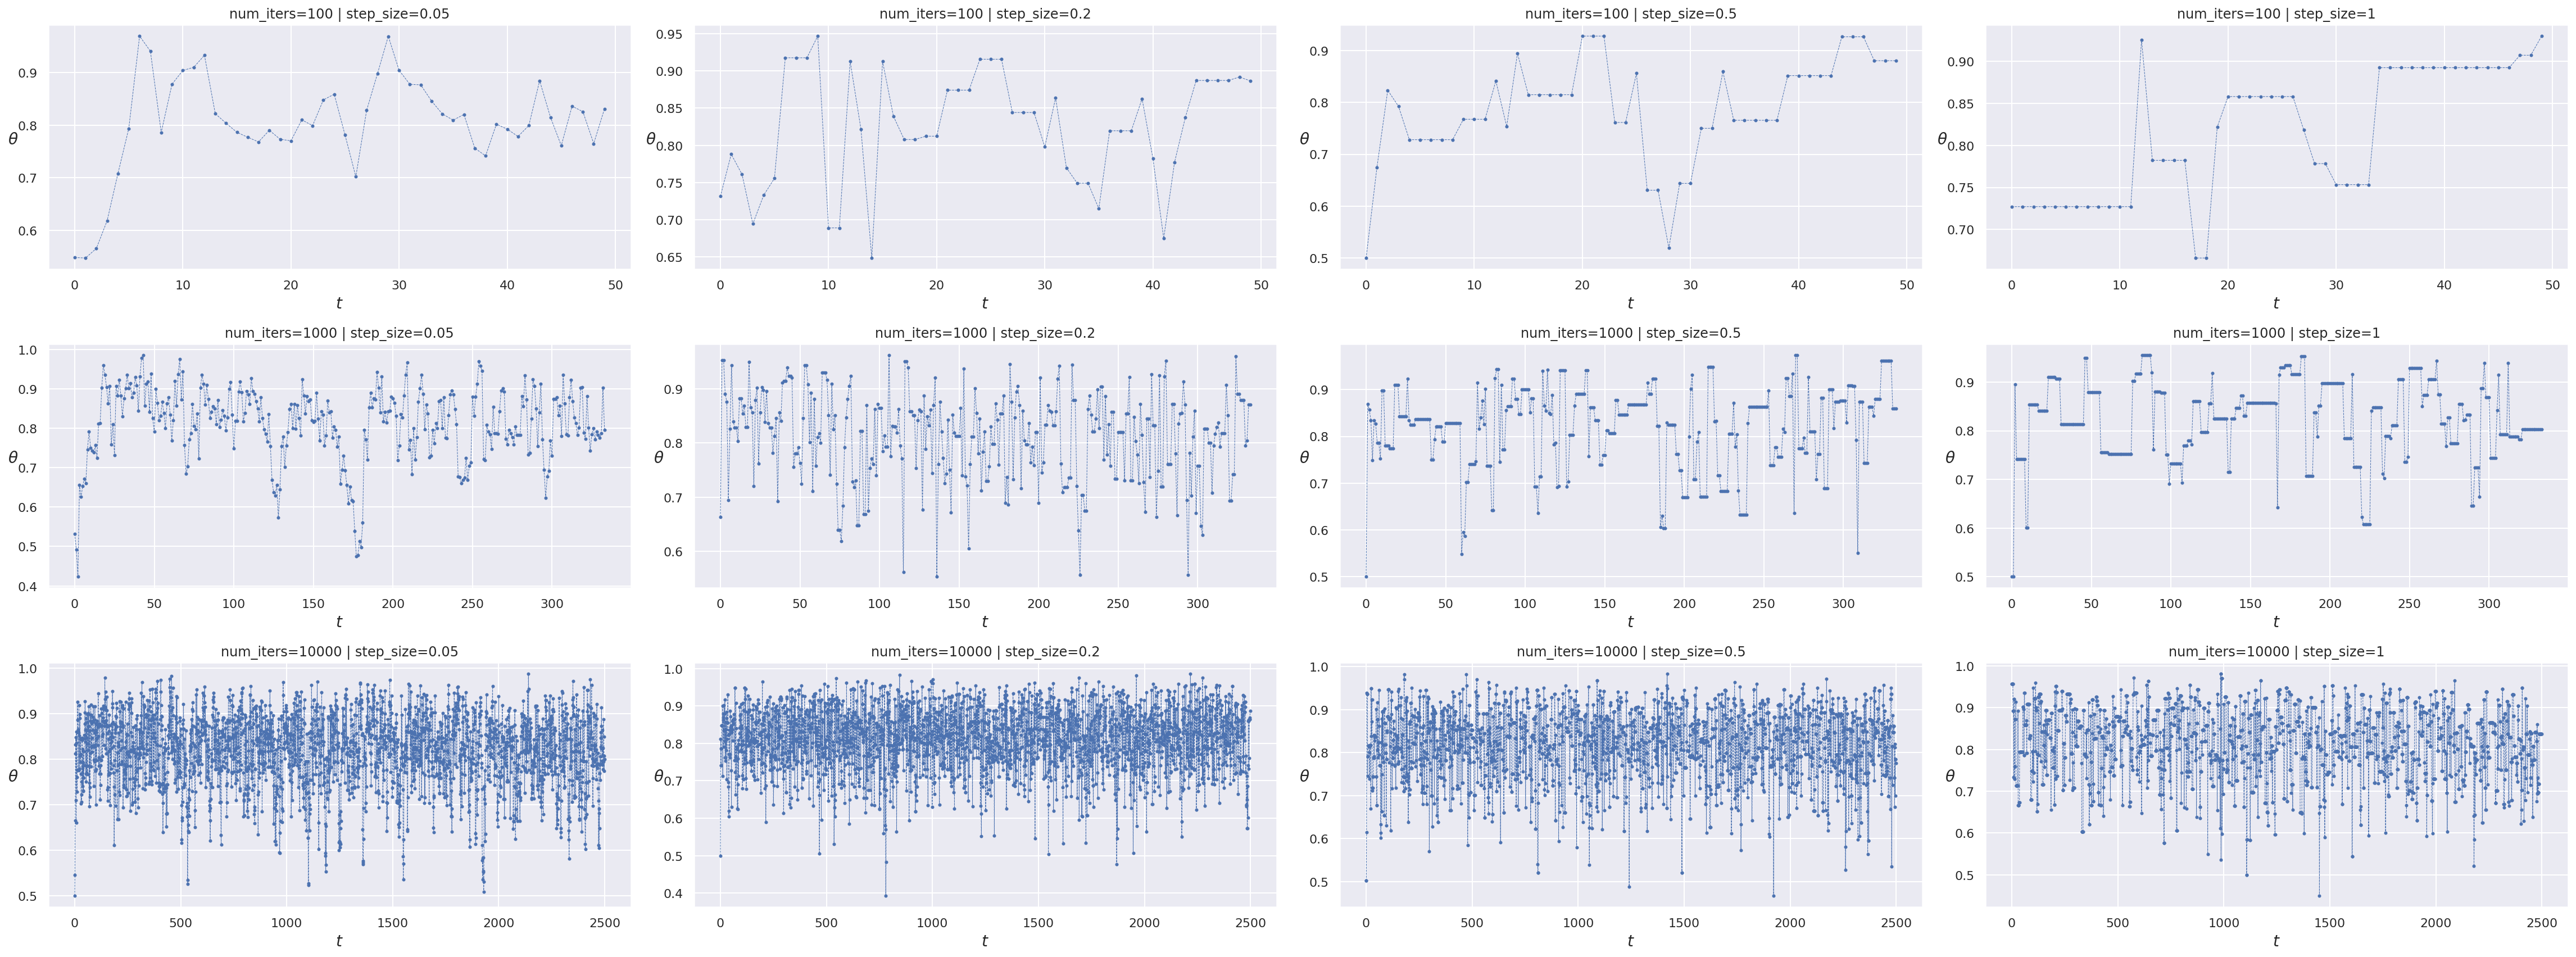

In [6]:
plt.figure(figsize=(32, 12))

for i in range(len(posteriors)):
    p = posteriors[i]
    
    plt.subplot(3, 4, i+1)
    plt.title(f"num_iters={p['num_iters']} | step_size={p['step_size']}", fontsize=12)
    
    plt.plot(p['samples'][::int(np.log10(p['num_iters']))], linestyle='--', marker='o', lw=0.5, markersize=2)
    plt.ylabel(r'$\theta$', fontsize=14, rotation=0)
    plt.xlabel('$t$', fontsize=14)

plt.tight_layout()